# Self Consistent Photochemistry and Climate with `Photochem`

This notebook will take us through how to run a self-consistent radiative-convective-photochemical-equilibrium (RCPE) model with PICASO and Photochem. 

For a more in depth look at the photochem code check out [Wogan et al. 2025](https://ui.adsabs.harvard.edu/abs/2025PSJ.....6..256W/abstract) (note this should also be cited along with [PICASO 4.0]() if using this code/tutorial). 


Here, we will use WASP-39 b as an example. We will begin by importing several packages required for the run.

In [1]:
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import picaso.photochem as picasochem
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy import constants as const
from astropy import units as u
import pandas as pd

/Users/nicholas/Downloads/picaso/picaso/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import declare_namespace


The following cell generates a reaction network, thermodynamic file and UV spectrum required for running photochem.

In [2]:
# Generate files needed for Photochem

# Reaction and Thermodynamic files
picasochem.generate_photochem_rx_and_thermo_files(
    atoms_names=['H','He','N','O','C','S'], # Atoms to include
    rxns_filename='photochem_rxns.yaml',
    thermo_filename='photochem_thermo.yaml'
)

# Stellar Spectrum. Here we choose TOI-193, a sensible
# Proxy for WASP-39 b. We have to set the Teq so that the
# Spectrum is scale to the planet.
from photochem.utils import stars
wv, F = stars.muscles_spectrum(
    'TOI-193',
    outputfile='TOI-193.txt',
    Teq=1166
)

Initialize an opacity class, specifying the molecules you want to include opacities for.

In [3]:
gases_fly = [
    'H2O','NH3','CO2','N2','HCN',
    'H2','C2H2','C2H4','C2H6','Na',
    'K','PH3','TiO','VO','FeH',
    'SO2','H2S'
]
opacity_ck = jdi.opannection(
    method='resortrebin',
    preload_gases=gases_fly
)

/Users/nicholas/Downloads/picaso/picaso/optics.py:1410: UserWarning: Warning: npy files for DEQ will be deprecated in a future PICASO udpate. Please download the hdf5 files, explanation here https://natashabatalha.github.io/picaso/notebooks/climate/12c_BrownDwarf_DEQ.html
  warnings.warn(' '.join(np.unique(msg)), UserWarning)


Initialize a calculation, specifying WASP-39 b parameters.

In [ ]:
def make_inputs(kz=1e8, filename_guess=None):

    # Start a calculation
    cl_run = jdi.inputs(calculation="planet", climate=True) # start a calculation
    
    # Gravity
    r_planet = (1.332*const.R_jup).to(u.cm).value
    m_planet = (0.28*const.M_jup).to(u.g).value
    cl_run.gravity(
        radius=r_planet,
        radius_unit=u.cm, 
        mass=m_planet, 
        mass_unit=u.g
    )
    
    # Effective Temp
    tint = 200 # Intrinsic Temperature of your Planet in K
    cl_run.effective_temp(tint) # input effective temperature
    
    # Star
    T_star = 5485 # K, star effective temperature
    logg = 4.45 # logg , cgs
    metal = 0.01 # metallicity of star
    r_star = 0.92 # solar radius
    semi_major = 0.049 # star planet distance, AU
    cl_run.star(
        opacity_ck, 
        temp=T_star,
        metal=metal,
        logg=logg, 
        radius=r_star,
        radius_unit=u.R_sun,
        semi_major=semi_major,
        semi_major_unit=u.AU,
        database="phoenix"
    )
    
    # Guess the initial P-T profile
    nlevel = 91 # number of plane-parallel levels in your code
    if filename_guess is None:
        Teq = T_star*np.sqrt(0.5*r_star*0.00465047/semi_major)
        pt = cl_run.guillot_pt(
            Teq, 
            nlevel=nlevel, 
            T_int=tint, 
            p_bottom=3.0, 
            p_top=-7
        )
        temp_guess = pt['temperature'].values
        pressure = pt['pressure'].values
    else:
        df1 = pd.read_csv("W39b_+1.0_0.3_kzz8",sep="\t")
        temp_guess = df1['temperature'].values
        pressure = df1['pressure'].values
    
    rcb_guess = 78
    rfacv = 0.5 # Heat-redistribution
    
    # Set climate inputs
    cl_run.inputs_climate(
        temp_guess=temp_guess, 
        pressure=pressure,
        rcb_guess=rcb_guess,
        rfacv=rfacv
    )
    
    # Below, we will provide the inputs required to run photochem. 
    # The key things to change are planet mass, planet radius, 
    # stellar XUV flux file.
    photochem_init_args={
        'mechanism_file': "photochem_rxns.yaml",
        'thermo_file': "photochem_thermo.yaml",
        'stellar_flux_file': "TOI-193.txt",
        'P_ref': 1e6, # dynes/cm^2
        'TOA_pressure': 1e-8*1e6 #dynes/cm^2
    }
    cl_run.atmosphere(
        mh=10, 
        cto_relative=0.3, 
        chem_method='photochem+visscher', 
        photochem_init_args=photochem_init_args
    )
    # Grab the Photochem object and adjust any settings if needed
    pc = cl_run.inputs['climate']['pc']
    pc.var.conv_longdy = 0.05 # relax convergence criteria for photochem.
    
    # Set the Kzz profile.
    cl_run.inputs['atmosphere']['profile']['kz'] = kz # cm^2/s

    return cl_run

cl_run = make_inputs()

Now run the model. This might take a looongg time. So please be patient.

In [5]:
out = cl_run.climate(
    opacity_ck, 
    save_all_profiles=True,
    save_all_kzz=False,
    self_consistent_kzz=False,
    diseq_chem=True
) 

SUMMARY
-------
Clouds: False
quench False
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False
Computed quenched levels at {'CO-CH4-H2O': 52, 'CO2': 35, 'NH3-N2': 54, 'HCN': 51, 'PH3': 44}
Running photochem
nsteps = 100  longdy = 2.2e+01  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08
nsteps = 200  longdy = 2.5e+01  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.1e-08
nsteps = 300  longdy = 2.0e+02  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08
nsteps = 400  longdy = 2.8e+01  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08
nsteps = 500  longdy = 1.3e+01  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08
nsteps = 600  longdy = 2.4e+02  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.3e-08
nsteps = 700  longdy = 1.1e+02  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.6e-08
nsteps = 800  longdy = 9.0e+00  max_dT = 1.0e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 2

Plot the results

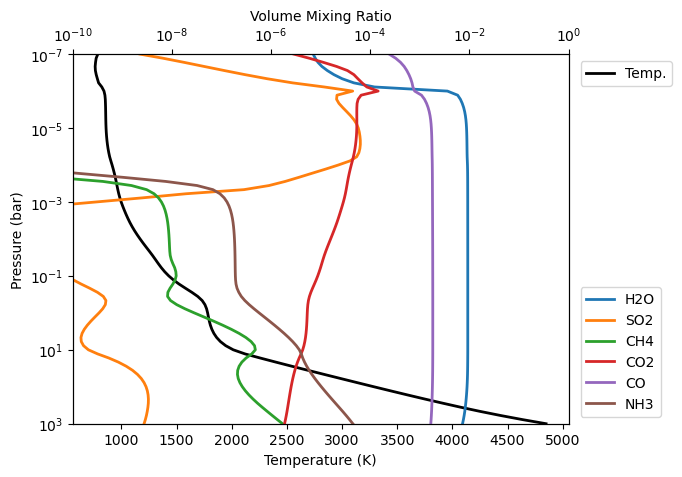

In [6]:
fig, ax = plt.subplots(1,1)

# P-T profile
ax.plot(out['ptchem_df']['temperature'], out['ptchem_df']['pressure'], c='k', lw=2, label='Temp.')
ax.set_yscale('log')
ax.set_ylim(1e3, 1e-7)
ax.set_ylabel('Pressure (bar)')
ax.set_xlabel('Temperature (K)')
ax.legend(ncol=1, bbox_to_anchor=(1.01,1.0),loc='upper left')

# Composition
ax1 = ax.twiny()
ax1.plot()
for i,sp in enumerate(['H2O','SO2','CH4','CO2','CO','NH3']):
    ax1.plot(out['ptchem_df'][sp], out['ptchem_df']['pressure'], c='C'+str(i), label=sp, lw=2)

ax1.set_xscale('log')
ax1.set_xlim(1e-10, 1)
ax1.set_xlabel('Volume Mixing Ratio')
ax1.legend(ncol=1, bbox_to_anchor=(1.01,0.0),loc='lower left')

plt.show()

Save the atmosphere to a file.

In [7]:
out['ptchem_df'].to_csv("W39b_+1.0_0.3_kzz8",sep="\t")

Now lets use this model as a guess and run a model with $K_{zz}$ = 1e11 cm$^2$/s instead.

In [8]:
# Make new inputs object with kz set to 1e11
cl_run = make_inputs(kz=1e11, filename_guess="W39b_+1.0_0.3_kzz8")

# Run climate model
out2 = cl_run.climate(
    opacity_ck, 
    save_all_profiles=True,
    save_all_kzz=False,
    self_consistent_kzz=False,
    diseq_chem=True
) 

# Save results
out2['ptchem_df'].to_csv("W39b_+1.0_0.3_kzz11",sep="\t")

SUMMARY
-------
Clouds: False
quench False
cold_trap False
vol_rainout False
no_ph3 False
Moist Adiabat: False
Computed quenched levels at {'CO-CH4-H2O': 61, 'CO2': 46, 'NH3-N2': 66, 'HCN': 60, 'PH3': 53}
Running photochem
nsteps = 100  longdy = 8.9e+00  max_dT = 3.9e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08
nsteps = 200  longdy = 2.8e+01  max_dT = 4.1e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08
nsteps = 300  longdy = 3.2e+01  max_dT = 4.5e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08
nsteps = 400  longdy = 3.2e+02  max_dT = 5.3e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08
nsteps = 500  longdy = 1.1e+03  max_dT = 6.4e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.2e-08
nsteps = 600  longdy = 1.3e+02  max_dT = 8.7e+00  max_dlog10edd = 0.0e+00  TOA_pressure = 1.4e-08
nsteps = 700  longdy = 2.5e+00  max_dT = 1.3e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 1.8e-08
nsteps = 800  longdy = 5.7e-01  max_dT = 1.6e+01  max_dlog10edd = 0.0e+00  TOA_pressure = 2

Compare the TP profiles between the two Kzz values

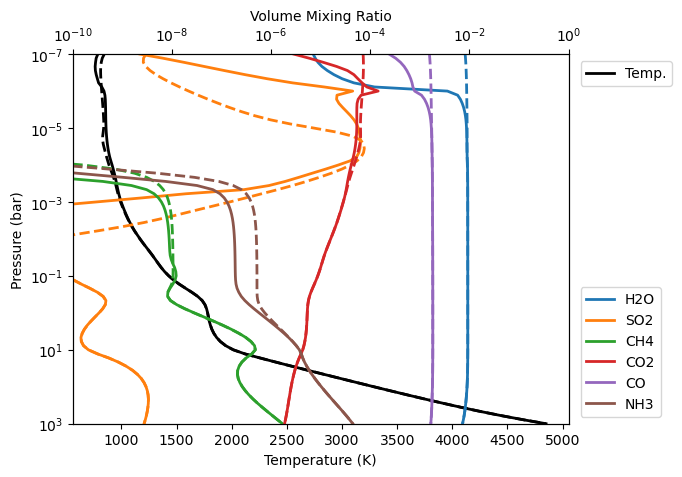

In [10]:
fig, ax = plt.subplots(1,1)

# P-T profile
ax.plot(out['ptchem_df']['temperature'], out['ptchem_df']['pressure'], c='k', lw=2, label='Temp.')
ax.plot(out2['ptchem_df']['temperature'], out2['ptchem_df']['pressure'], c='k', lw=2, ls='--')
ax.set_yscale('log')
ax.set_ylim(1e3, 1e-7)
ax.set_ylabel('Pressure (bar)')
ax.set_xlabel('Temperature (K)')
ax.legend(ncol=1, bbox_to_anchor=(1.01,1.0),loc='upper left')

# Composition
ax1 = ax.twiny()
ax1.plot()
for i,sp in enumerate(['H2O','SO2','CH4','CO2','CO','NH3']):
    ax1.plot(out['ptchem_df'][sp], out['ptchem_df']['pressure'], c='C'+str(i), label=sp, lw=2)
    ax1.plot(out2['ptchem_df'][sp], out2['ptchem_df']['pressure'], c='C'+str(i), lw=2, ls='--')

ax1.set_xscale('log')
ax1.set_xlim(1e-10, 1)
ax1.set_xlabel('Volume Mixing Ratio')
ax1.legend(ncol=1, bbox_to_anchor=(1.01,0.0),loc='lower left')

plt.show()